In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
sms_df = pd.read_csv('spam.csv', encoding='latin-1')
sms_df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
sms_df.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [5]:
sms_df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis='columns', inplace=True)

In [6]:
sms_df.rename(columns={'v1':'label', 'v2': 'message'}, inplace=True)

In [7]:
sms_df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
spam_text = sms_df[sms_df['label'] == 'spam']
ham_text = sms_df[sms_df['label'] == 'ham']

In [40]:
spam_text.head()

,label,message
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
5,spam,FreeMsg Hey there darling it's been 3 week's n...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po..."


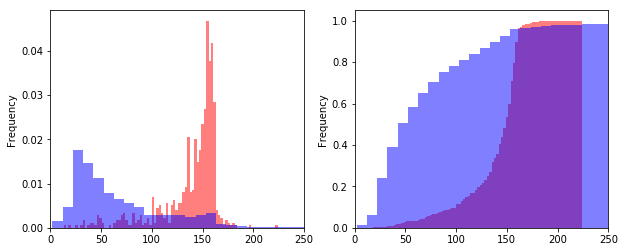

In [8]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
spam_length = spam_text['message'].apply(len)
ham_length = ham_text['message'].apply(len)
spam_length.plot(kind='hist',bins=90,alpha=0.5,color='r',normed=True)
ham_length.plot(kind='hist',bins=90,alpha=0.5,color='b', normed=True)
plt.xlim((0,250))
plt.subplot(1,2,2)
plt.xlim((0,250))
spam_length.plot(kind='hist',bins=90,alpha=0.5,color='r',normed=True, cumulative=True)
ham_length.plot(kind='hist',bins=90,alpha=0.5,color='b', normed=True, cumulative=True)
plt.show()

In [79]:
import nltk
from nltk.corpus import stopwords
spam_string = ''
for text in spam_text['message'].str.lower():
    token_words = nltk.word_tokenize(text)
    for word in token_words:
        spam_string += ' ' + word
        
ham_string = ''
for text in ham_text['message'].str.lower():
    token_words = nltk.word_tokenize(text)
    for word in token_words:
        ham_string += ' ' + word

In [80]:
from wordcloud import WordCloud
wordcloud_spam = WordCloud(width=750, height=450, background_color="black", 
                           stopwords=stopwords.words('english')).generate(spam_string)
wordcloud_ham = WordCloud(width=750, height=450, background_color="white", 
                           stopwords=stopwords.words('english')).generate(ham_string)

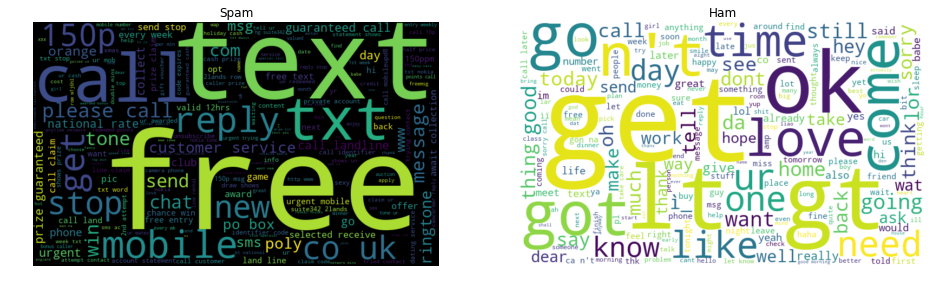

In [92]:
fig, (axes_spam, axes_ham) = plt.subplots(1,2,figsize=(16,10))

axes_spam.imshow(wordcloud_spam, interpolation='bilinear')
axes_spam.axis("off")
axes_spam.set_title('Spam')

axes_ham.axis("off")
axes_ham.set_title('Ham')
axes_ham.imshow(wordcloud_ham, interpolation='bilinear')

plt.show()

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [10]:
message_train,message_test,label_train,label_test = train_test_split(sms_df["message"],sms_df["label"], test_size = 0.3, random_state = 10)

In [11]:
print(message_train.shape)
print(message_test.shape)

(3900,)
(1672,)


In [13]:
cvec = CountVectorizer()
cvec.fit(message_train)
message_train_mat = cvec.transform(message_train)
message_test_mat = cvec.transform(message_test)

In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [109]:
model = MultinomialNB()
model.fit( message_train_mat,label_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [110]:
prediction = model.predict(message_test_mat)
accuracy_score(label_test,prediction)

0.98923444976076558

In [17]:
print(confusion_matrix(label_test,prediction))

[[1440    6]
 [  12  214]]


In [18]:
from xgboost import XGBClassifier

In [49]:
params ={'booster':'dart', 'objective': 'reg:logistic', 'max_depth':5}
modelXg = XGBClassifier(**params)
modelXg.fit(message_train_mat,label_train)

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [50]:
prediction = modelXg.predict(message_test_mat)
accuracy_score(label_test,prediction)

0.97727272727272729

In [51]:
print(confusion_matrix(label_test,prediction))

[[1438    8]
 [  30  196]]


In [52]:
from sklearn.model_selection import GridSearchCV

In [121]:
parameters = {'alpha': (10, 1e-3)}

In [122]:
model_search = GridSearchCV(model, parameters)
model_search = gs_clf.fit(message_train_mat,label_train)

In [123]:
prediction = model_search.predict(message_test_mat)
accuracy_score(label_test,prediction)

0.98803827751196172

In [124]:
model_search.best_params_

{'alpha': 0.01}